In [2]:
!pip install transformers datasets peft bitsandbytes accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### LOAD MODEL

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "ngoan/Llama-2-7b-vietnamese-20k"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype="auto")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/183 [00:00<?, ?B/s]

### BUILD PROMPT

In [4]:
def build_prompt(text):
    return f"""Văn bản sau là một tin tức. Hãy phân loại là:
- 0 nếu đáng tin (tin thật)
- 1 nếu không đáng tin (tin giả)

Chỉ trả lời **0** hoặc **1**. Không giải thích.

Ví dụ:
Văn bản: "Chính phủ công bố gói hỗ trợ 350 nghìn tỷ cho doanh nghiệp nhỏ."
Nhãn: 0

Văn bản: "Ca sĩ Hòa Minzy bị bắt vì buôn lậu vũ khí hạt nhân."
Nhãn: 1

Văn bản: "NASA xác nhận Trái Đất sắp va chạm với sao Diêm Vương vào tháng tới."
Nhãn: 1

Văn bản: \"{text}\"

Nhãn:"""


### CLASSIFY NEWS

In [5]:
import torch
import gc

def classify(text):
    prompt = build_prompt(text)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    try:
        with torch.no_grad():
            output = model.generate(
                **inputs,
                max_new_tokens=10,
                do_sample=False
            )

        # Chỉ lấy phần mô hình sinh ra (không tính prompt)
        decoded_only = tokenizer.decode(
            output[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        ).strip()

        if not decoded_only:
            print("⚠️ Output rỗng từ mô hình.")
            return ""

        return decoded_only  # Trả về nguyên chuỗi để xử lý sau
    finally:
        # Luôn dọn dẹp bộ nhớ, kể cả khi lỗi
        del inputs, output
        torch.cuda.empty_cache()
        gc.collect()


classify('''
VNINDEX đạt 1500 điểm chỉ sau 3 tháng kể từ sự kiện thiên nga đen. Sốc quá. Vãi. Lừa đảo
''')


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


'0\nNhãn: 0'

### PREDICT AND SAVE RESULT

In [6]:

import os
import gc
import torch
import pandas as pd
from tqdm import tqdm

test_path = '/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/reintel_dataset/test.csv'
result_path = "/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/LLMs/prediction_llamazero.csv"

#Đọc file
df = pd.read_csv(test_path)

# Giúp giảm phân mảnh RAM CUDA
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Khởi tạo danh sách lưu kết quả
predictions = []

# Đảm bảo dọn RAM trước khi chạy
torch.cuda.empty_cache()
gc.collect()

for idx, text in tqdm(enumerate(df["post_message"]), total=len(df), desc="Đang phân loại"):
    success = False
    retry_count = 0
    max_retry = 3  # cố gắng tối đa 3 lần nếu bị lỗi

    while not success and retry_count < max_retry:
        try:
            pred = classify(text)
            predictions.append(pred)
            success = True
        except torch.cuda.OutOfMemoryError as e:
            print(f"[{idx}] ❌ OOM: {e}, đang dọn bộ nhớ và thử lại ({retry_count + 1}/{max_retry})...")
            torch.cuda.empty_cache()
            gc.collect()
            retry_count += 1
        except Exception as e:
            print(f"[{idx}] ⚠️ Lỗi không xác định: {e}, trả về None")
            predictions.append(None)
            success = True  # vẫn tiếp tục vì lỗi không hồi được

    # Nếu thử nhiều lần vẫn fail → append None để không dừng toàn bộ
    if not success:
        print(f"[{idx}] ❌ Không thể phân loại sau {max_retry} lần thử. Ghi None.")
        predictions.append(None)

    # Tùy chọn: lưu tạm sau mỗi 10 mẫu để tránh mất dữ liệu
    if idx % 10 == 0 and idx > 0:
        df_temp = df.iloc[:idx + 1].copy()
        df_temp["predict"] = predictions
        df_temp.to_csv("temp_backup_predictions.csv", index=False)

# Gán kết quả vào DataFrame gốc
df["predict"] = predictions

# Lưu file cuối
df.to_csv(result_path, index=False)
print("✅ Đã phân loại xong toàn bộ văn bản.")


Đang phân loại:   3%|▎         | 13/486 [00:24<14:06,  1.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[12] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:   8%|▊         | 39/486 [01:03<11:18,  1.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[38] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  11%|█         | 53/486 [01:24<12:38,  1.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[52] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  20%|██        | 98/486 [02:36<10:03,  1.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[97] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  23%|██▎       | 111/486 [02:55<09:41,  1.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[110] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  25%|██▍       | 120/486 [03:08<09:38,  1.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[119] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  29%|██▉       | 143/486 [03:42<08:55,  1.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[142] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  31%|███       | 150/486 [03:52<08:30,  1.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[149] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  31%|███▏      | 152/486 [03:55<09:23,  1.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[151] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  32%|███▏      | 154/486 [03:59<09:33,  1.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[153] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  35%|███▍      | 170/486 [04:24<09:05,  1.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[169] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  36%|███▋      | 177/486 [04:35<08:10,  1.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[176] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  38%|███▊      | 187/486 [04:50<07:30,  1.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[186] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  46%|████▋     | 225/486 [05:44<07:41,  1.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[224] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  48%|████▊     | 234/486 [05:57<06:28,  1.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[233] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  50%|█████     | 244/486 [06:12<06:50,  1.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[243] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  51%|█████     | 246/486 [06:16<06:40,  1.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[245] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  55%|█████▍    | 265/486 [06:45<06:24,  1.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[264] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  55%|█████▌    | 268/486 [06:50<06:09,  1.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[267] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  59%|█████▊    | 285/486 [07:13<05:05,  1.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[284] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  59%|█████▉    | 289/486 [07:19<05:03,  1.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[288] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  61%|██████▏   | 298/486 [07:34<05:06,  1.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[297] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  67%|██████▋   | 324/486 [08:14<04:20,  1.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[323] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  69%|██████▊   | 333/486 [08:27<03:58,  1.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[332] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  69%|██████▉   | 336/486 [08:32<04:20,  1.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[335] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  71%|███████▏  | 347/486 [08:50<03:48,  1.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[346] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  73%|███████▎  | 357/486 [09:06<03:46,  1.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[356] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  76%|███████▌  | 368/486 [09:25<03:44,  1.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[367] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  84%|████████▍ | 409/486 [10:27<02:00,  1.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[408] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  86%|████████▋ | 420/486 [10:45<01:54,  1.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[419] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  89%|████████▊ | 431/486 [11:03<01:30,  1.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[430] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  89%|████████▉ | 432/486 [11:04<01:11,  1.32s/it]

[431] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Đang phân loại:  92%|█████████▏| 446/486 [11:25<01:03,  1.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[445] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


Đang phân loại:  95%|█████████▌| 464/486 [11:54<00:33,  1.54s/it]

[463] ⚠️ Lỗi không xác định: cannot access local variable 'output' where it is not associated with a value, trả về None


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Đang phân loại: 100%|██████████| 486/486 [12:29<00:00,  1.54s/it]

✅ Đã phân loại xong toàn bộ văn bản.


In [7]:
def map_to_label(pred):
    if not isinstance(pred, str):
        return 0
    text = pred.lower()
    if "giả" in text or "fake" in text or "sai sự thật" in text or text.strip().startswith("1"):
        return 1
    return 0


df["label_mapped"] = df["predict"].apply(map_to_label)
df.to_csv(result_path, index=False)

### VALIDATE THE LLM MODEL

In [8]:
acc = (df['label_mapped'] == df['label']).mean()
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.6749


🔹 Đánh giá mô hình:
  - Accuracy : 0.6749
  - Precision: 0.1780
  - Recall   : 0.2561
  - F1-score : 0.2100
  - AUC      : 0.5080


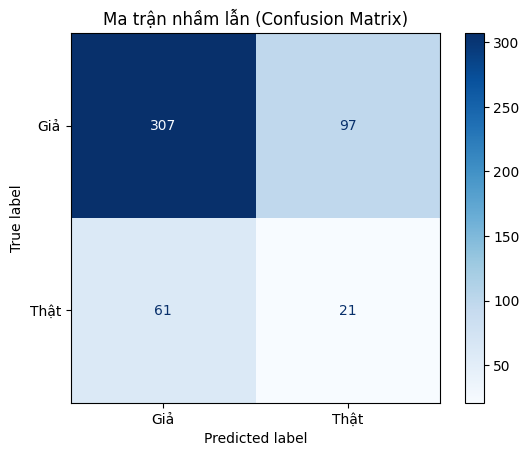

In [10]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Đọc dữ liệu từ file CSV
df = pd.read_csv(result_path)

# Giả sử label và predict là kiểu số nguyên (0 hoặc 1)
y_true = df['label']
y_pred = df['label_mapped']

# Tính các chỉ số đánh giá
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc = roc_auc_score(y_true, y_pred)  # Ước lượng từ nhãn nhị phân

# In kết quả ra màn hình
print("🔹 Đánh giá mô hình:")
print(f"  - Accuracy : {accuracy:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall   : {recall:.4f}")
print(f"  - F1-score : {f1:.4f}")
print(f"  - AUC      : {auc:.4f}")

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Giả', 'Thật'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Ma trận nhầm lẫn (Confusion Matrix)")
plt.show()
